In [481]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [456]:
data_dir = r"C:\Users\Adam\Data\Lisa\platelets\Platelet data 2018-05-12"

In [457]:
def find_files( data_dir, pattern ):
    
    results = []
    
    for root, dirs, files in os.walk(data_dir):
        for file in files: # loops through directories and files
            if pattern in file: # compares to your specified conditions
                results.append( os.path.join(root,file))
    return results

def csv_list_to_dataframe( csv_list ):
    df_list = []
    for file in csv_list:
        df =  pd.read_csv(file)
        
        df['Source'] = file
        
        df.columns = [c.lstrip('0123456789_').strip('_') for c in df.columns]
        
        for c in df.columns:
            if '.1' in c:
                print(file)
                print(c)
            if c[-1] =='_':
                print(file)
                print(c)
        
        df_list.append( df )
    return pd.concat( df_list )
        

In [458]:
file_list = find_files(data_dir, '.csv')

df = csv_list_to_dataframe( file_list )

df['Replicate Number'] = df['Source'].str.extract(r"Rep ([0-9])", expand = False).astype(int)
df['Fraction'] = df['Source'].str.extract(r"(supe|pellet)", expand = False)
df['Mode'] = df['Source'].str.extract(r"(pos|neg)", expand = False)
df['Treatment'] = df['Source'].str.extract(r"(activated|blank|hsd1|hsd2)", expand = False)

In [459]:
df = df[ [c for c in df.columns if ( ('dil' not in c) & ('repeat' not in c) & ('NEW' not in c) )]]

In [460]:
for c in df.columns:
    print(c)

.05.2018 19:49
DESKTOP-AG4GG5R/Adam
Source
Unnamed: 0
Unnamed: 2
activated_pellet_a_neg
activated_pellet_a_pos
activated_pellet_b_neg
activated_pellet_b_pos
activated_supe_a_neg
activated_supe_a_pos
activated_supe_b_neg
activated_supe_b_pos
blank_mid_a_neg
blank_mid_a_pos
blank_mid_b_neg
blank_mid_b_pos
blank_post_a_neg
blank_post_a_pos
blank_post_b_neg
blank_post_b_pos
blank_pre_a_neg
blank_pre_a_pos
blank_pre_b_neg
blank_pre_b_pos
blank_pre_c_neg
blank_pre_c_pos
buffer_pellet_a_neg
buffer_pellet_a_pos
buffer_pellet_b_neg
buffer_pellet_b_pos
buffer_supe_a_neg
buffer_supe_a_pos
buffer_supe_b_neg
buffer_supe_b_pos
compound
compoundId
expectedRtDiff
file:///C:/Users/Adam/AppData/Roaming/LibreOffice/4;
goodPeakCount
groupId
hsd1_pellet_a_neg
hsd1_pellet_a_pos
hsd1_pellet_b_neg
hsd1_pellet_b_pos
hsd1_supe_a_neg
hsd1_supe_a_pos
hsd1_supe_b_neg
hsd1_supe_b_pos
hsd2_pellet_a_neg
hsd2_pellet_a_pos
hsd2_pellet_b_neg
hsd2_pellet_b_pos
hsd2_supe_a_neg
hsd2_supe_a_pos
hsd2_supe_b_neg
hsd2_supe_b_p

In [461]:
df.Fraction.value_counts()

supe      550
pellet    474
Name: Fraction, dtype: int64

In [462]:
df['compound'].value_counts()

PC(40:7)                                  9
PC(38:6)                                  9
PC(40:6)                                  9
PC(38:5)                                  7
PS(38:4)                                  7
PE(36:2)                                  7
PE(36:4)                                  7
PE(36:1)                                  7
PI(38:4)                                  7
PC(32:0)                                  6
TG_NH4(56:2)                              6
PC(40:8)                                  6
SM (d18:1/24:0)                           6
SM(d18:1/24:1)                            6
PE(40:4)                                  6
PC(38:4)                                  6
Sphingosine-dihydro(d18:0)(Safingol)      6
LPE(20:4)                                 6
PE(36:3)                                  6
SM(d18:1/16:0)                            5
TG_NH4(56:5)                              5
TG_NH4(56:7)                              5
SM(d18:1/18:0)                  

In [463]:
df.groupby(['compound']).apply(lambda x: len(x['Replicate Number'].unique())).value_counts()

1    250
2    154
3     66
dtype: int64

above - a quick check to see how many compounds show up in at least 1 sample in each replicate

In [483]:
for lbl, grp in df[(df['Mode'] == 'pos')&(df['Fraction']=='supe')].set_index('Replicate Number').groupby(['compound']):
    
    if grp.shape[0] < 3:
        continue
        
    data = grp[ [c for c in grp.columns[1:-7] if '_' in c] ].T.copy()

    data = data.reset_index()
    
    
    data['Fraction'] = data['index'].str.extract(r"(supe|pellet|blank)", expand = False)
    data['Mode'] = data['index'].str.extract(r"(pos|neg)", expand = False)
    data['Treatment'] = data['index'].str.extract(r"(activated|blank|hsd1|hsd2|non|buffer)", expand = False)
    
    if lbl == 'PE(36:3)':
        break
    print(lbl)

PC(32:0)
PC(38:2)
PC(38:4)
PC(38:5)
PC(38:6)
PC(40:6)
PC(40:7)
PC(40:8)


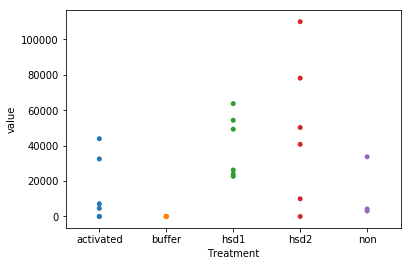

In [484]:
q = data[ (data['Fraction'] == 'supe') & (data['Mode'] == 'pos') ]
q = q.melt(id_vars = 'Treatment', value_vars = q.columns[1:-3])
sns.stripplot( data = q, x = 'Treatment', y = 'value')
plt.show()